In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore' # set environment to ignore all warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch #adding color to charts
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [44]:
# load the data
# app_test = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/application_test.csv')
app_train = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/application_train.csv') #, na_values='')
# bur_bal = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/bureau_balance.csv', na_values='np.nan')
# bur = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/bureau.csv').fillna(value=np.nan)
# credcard = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/credit_card_balance.csv', na_values='np.nan')
# inst_pymt = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/installments_payments.csv', na_values='')
# pos_cash = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/POS_CASH_balance.csv', na_values='')
# prev_app = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/previous_application.csv', na_values='')
# # sam_sub = pd.read_csv('/content/drive/MyDrive/notebooks/scoring_model/sample_submission.csv')

In [45]:
# !pip install kaggle
# !kaggle datasets download -d home-credit-default-risk/application_train
# app = pd.read_csv('application_train.csv')
# app = pd.read_csv('https://www.kaggle.com/c/home-credit-default-risk/data?select=application_train.csv', engine='python')
# app.head()

In [46]:
# # # check shape of dataframe and datatypes of the coluomns
# app_train = app_train.set_index('SK_ID_CURR')
# app_train.info()
df = app_train.copy()
df = df.set_index('SK_ID_CURR')
# Check if there are any duplicated rows and drop them.
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [47]:
# Count missing values
def create_na_df(df):
    num_mis = df.isna().sum()
    perc = (num_mis/len(df)*100).map('{:,.2f}'.format)
    return pd.DataFrame({"cnt_miss": num_mis.values, "perc_miss":perc})

create_na_df(df)

,cnt_miss,perc_miss
TARGET,0,0.00
NAME_CONTRACT_TYPE,0,0.00
CODE_GENDER,0,0.00
FLAG_OWN_CAR,0,0.00
FLAG_OWN_REALTY,0,0.00
...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.50
AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.50
AMT_REQ_CREDIT_BUREAU_MON,41519,13.50
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.50


In [48]:
# summary of float columns
# app_train[app_train.select_dtypes(float).columns].describe().transpose().map('{:,.2f}'.format)
# df.describe().transpose().map('{:,.2f}'.format)
# # summary of object columns
# app_train[app_train.select_dtypes(object).columns].describe().transpose()

In [49]:
# identify the day columns and remove values less than 0
df = df[(df.DAYS_BIRTH <0) & (df.DAYS_EMPLOYED<0) & (df.DAYS_ID_PUBLISH<0) & (df.DAYS_LAST_PHONE_CHANGE<0) & (df.DAYS_REGISTRATION<0)]

# Remove outliers in the DAYS_EMPLOYED and then combine with DAYS_BIRTH into a new column DAYS_WORK_PERC
df = df[(df.DAYS_EMPLOYED>=-14610) & (df.DAYS_EMPLOYED<0)]
df['DAYS_WORK_PERC'] = df['DAYS_EMPLOYED']/df['DAYS_BIRTH']
df = df.drop(columns=['DAYS_EMPLOYED', 'DAYS_BIRTH'], axis=1)
# change the datatypes of 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE',WALLSMATERIAL_MODE', EMERGENCYSTATE_MODE
df = df.astype({'NAME_TYPE_SUITE':'object', 'OCCUPATION_TYPE':'object', 'HOUSETYPE_MODE':'object',
                'WALLSMATERIAL_MODE':'object', 'EMERGENCYSTATE_MODE':'object'})

df.FLAG_OWN_CAR = np.where(df.FLAG_OWN_CAR.values == 'Y', 1, 0)
df.FLAG_OWN_REALTY = np.where(df.FLAG_OWN_REALTY.values =='Y',1, 0)

# these columns are the modes of the original columns
cols_to_drop = ['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
                'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
                'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
                'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']

# Remove the mode and median columns for those variables that are already summarized.
df = df.drop(cols_to_drop, axis=1)
df = df[df.CODE_GENDER!='XNA']


# drop highly correlated variables
df = df.drop(columns=['APARTMENTS_AVG', 'LIVINGAPARTMENTS_AVG', 'TOTALAREA_MODE', 'ELEVATORS_AVG',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'REGION_RATING_CLIENT'], axis=1)

<ipython-input-49-1f7d03d487f3>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
# Fill missing values of float columns with the mean
float_cols = df.select_dtypes(include=[float]).columns # get float column names
df[float_cols] = df[float_cols].fillna(df[float_cols].mean()) # fill with mean

# Fill missing values of int columns with the 3
int_cols = df.select_dtypes(include=[int]).columns # get float column names
df[int_cols] = df[int_cols].fillna(df[int_cols].median()) # fill with mean

# Fill missing values of object columns with the unknown
obj_cols = df.select_dtypes(include=[object]).columns # get float column names
df[obj_cols] = df[obj_cols].fillna('unknown') # fill with mean

In [51]:
# # Create a piecgart to show TARGET Count distribution
# gen = app_train.groupby(['TARGET'])['TARGET'].count().sort_values(ascending=False)
# plt.rcParams["figure.figsize"] = (9,7)
# gender_chart = gen.plot(kind='pie', y = 'Default', title ='Previous Loan Defaults', autopct='%1.1f%%')
# plt.show()

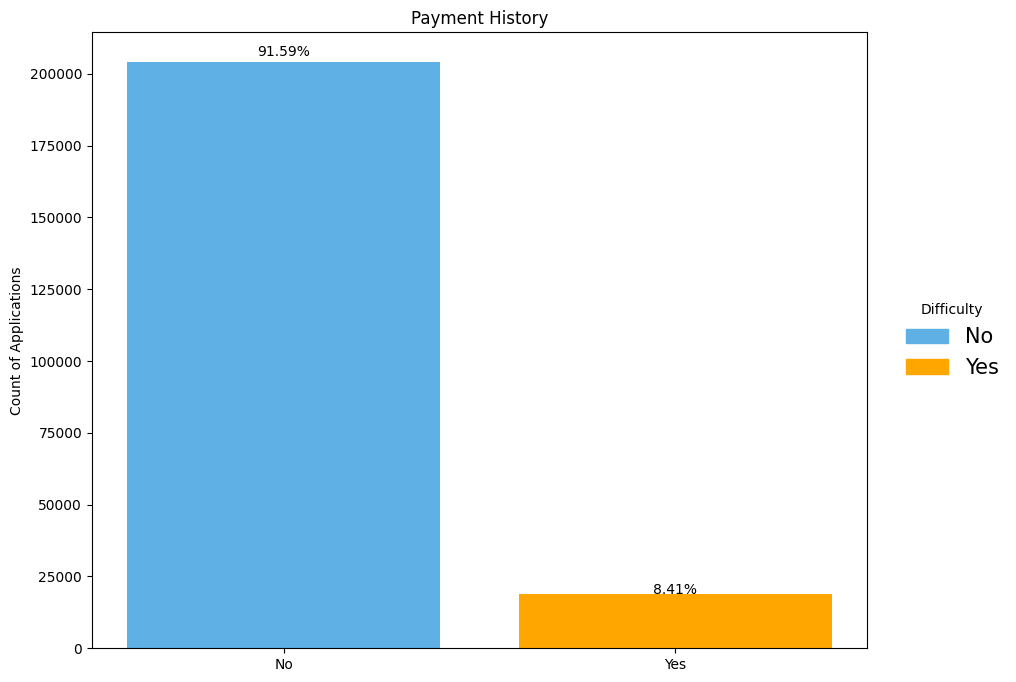

In [52]:
# get totals and calculate percentages
total = len(df.TARGET)
# calculate the total for each category and make a dataframe
grp = df.groupby(['TARGET']) # create seperate groups for 1 and 0
group = grp['TARGET'].count().sort_values(ascending=False).to_frame() # count occurances and make into dataframe
# compute percentage of each TARGET class
percentage = []
for i in range(group.shape[0]):
    pct = (group.TARGET[i] / total) * 100
    percentage.append(round(pct, 2))

group = group.rename(columns={'TARGET':'Difficulty'}).reset_index()
# display data
group['Percentage'] = percentage
# Change the TARGET entries from 0 to No and 1 to Yes
group.TARGET = group.TARGET.apply(lambda x: 'No' if x == 0 else x)
group.TARGET = group.TARGET.apply(lambda x: 'Yes' if x == 1 else x)
# Create a bar chart to show distribution of TARGET counts
plt.figure(figsize=(10, 8))
objects = list(group.TARGET) # create a list of TARGET classes
colors_list = ['#5eb0e5', '#ffa700']
graph = plt.bar(group.TARGET, group.Difficulty, color=colors_list)
plt.title('Payment History')

# map names to colors
cmaps = dict(zip(group.Difficulty, colors_list))

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()

    plt.text(x+width/2,
             y+height*1.01,
             str(group.Percentage[i])+'%',
             ha='center')
    i += 1

# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmaps.items()]

plt.xticks(rotation=0)
plt.ylabel('Count of Applications')
plt.legend(title='Difficulty',
           labels=objects,
           handles=patches,
           bbox_to_anchor=(1.04, 0.5),
           loc='center left',
           borderaxespad=0,
           fontsize=15,
           frameon=False)
plt.show()

In [53]:
# Using OneHotEncoder encode the categorical variables to number
cat_cols = df.select_dtypes(include=[object]).columns # get the object columns

# # Convert categorical data to numeric with `pd.get_dummies`
dummy = cat_cols.to_list()

df_dummies = pd.get_dummies(df, columns=dummy, dtype='int')
df_dummies.head()

,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ORGANIZATION_TYPE_University,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_unknown,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_unknown
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,0,1,0,202500.0,351000.0,0.018801,-3648.0,-2120,11.834776,...,0,0,0,1,0,0,1,0,0,0
100003,0,0,0,0,270000.0,1129500.0,0.003541,-1186.0,-291,11.834776,...,0,0,0,1,0,0,1,0,0,0
100004,0,1,1,0,67500.0,135000.0,0.010032,-4260.0,-2531,26.000000,...,0,0,0,0,0,1,0,0,0,1
100006,0,0,1,0,135000.0,297000.0,0.008019,-9833.0,-2437,11.834776,...,0,0,0,0,0,1,0,0,0,1
100007,0,0,1,0,121500.0,513000.0,0.028663,-4311.0,-3458,11.834776,...,0,0,0,0,0,1,0,0,0,1


In [54]:
# Separate the data into labels and features
from sklearn.preprocessing import StandardScaler
# Split our preprocessed data into features and target arrays
y = df_dummies['TARGET']
X = df_dummies.drop('TARGET',axis=1)

# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the float variables to ensure balanced magnitude/weight
X_train = StandardScaler().fit_transform(X_train)

In [55]:
# Import the necessary libraries for LogisticRegression
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

dummy_mod = DummyClassifier(strategy="most_frequent")
dummy_mod.fit(X_train, y_train)

dummy_pred = dummy_mod.predict(X_test)

# Generate a confusion matrix for the model
dummy_cm = confusion_matrix(y_test, dummy_pred)
dummy_cm_df = pd.DataFrame(
    dummy_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Print the classification report for the model
print("Confusion Matrix")
display(dummy_cm_df)

print("Classification Report")
print(classification_report(y_test, dummy_pred))
print(f"Accuracy Score : {accuracy_score(y_test, dummy_pred): .3f}, \
      Recall score: {recall_score(y_test,dummy_pred): .3f}")
print(f'Area Under Curve: {roc_auc_score(y_test, dummy_mod.predict_proba(X_test)[::,1]): .4f}')

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,40774,0
Actual 1,3821,0


Classification Report
              precision    recall  f1-score   support

           0       0.91      1.00      0.96     40774
           1       0.00      0.00      0.00      3821

    accuracy                           0.91     44595
   macro avg       0.46      0.50      0.48     44595
weighted avg       0.84      0.91      0.87     44595

Accuracy Score :  0.914,       Recall score:  0.000
Area Under Curve:  0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [56]:
# Instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
logit_mod = LogisticRegression(solver='lbfgs', random_state=13, fit_intercept=False)

# Fit the model using training data
logit_mod.fit(X_train, y_train)

# Make predictions using the testing data
y_logit = logit_mod.predict(X_test)

# Print the balanced_accuracy score of the model
print(f'Training Data Score: {logit_mod.score(X_train, y_train): .3f},\
       Testing Data Score: {logit_mod.score(X_test, y_test): .3f}')


# Generate a confusion matrix for the model
cm = confusion_matrix(y_test, y_logit)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Print the classification report for the model
print("Confusion Matrix")
display(cm_df)

print("Classification Report")
print(classification_report(y_test, y_logit))
print(f"Accuracy Score : {accuracy_score(y_test, y_logit): .3f}, \
      Recall score: {recall_score(y_test,y_logit): .3f}")
print(f'Area Under Curve: {roc_auc_score(y_test, logit_mod.predict_proba(X_test)[::,1]): .4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Training Data Score:  0.571,       Testing Data Score:  0.709
Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,30636,10138
Actual 1,2857,964


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.75      0.83     40774
           1       0.09      0.25      0.13      3821

    accuracy                           0.71     44595
   macro avg       0.50      0.50      0.48     44595
weighted avg       0.84      0.71      0.77     44595

Accuracy Score :  0.709,       Recall score:  0.252
Area Under Curve:  0.5253


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



In [57]:
# define class weights
w = {0:1, 1:9}

# define model
wt_logit = LogisticRegression(random_state=13, class_weight=w)
# wt_logit = LogisticRegression(class_weight=w)

# fit it
wt_logit.fit(X_train,y_train)
# test
y_wt = wt_logit.predict(X_test)
y_wt_pred = wt_logit.predict_proba(X_test)[::,1]
# performance
cm_wt = confusion_matrix(y_test, y_wt)
cm_wt_df = pd.DataFrame(cm_wt, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
# Print the classification report for the model
print("Confusion Matrix")
display(cm_wt_df)
print("Classification Report")
print(classification_report(y_test, y_wt))
print(f"Accuracy Score : {accuracy_score(y_test, y_wt): .3f},\
      Recall score: {recall_score(y_test,y_wt): .3f}")
print(f'Area Under Curve: {roc_auc_score(y_test, y_wt_pred): .3f}')

Confusion Matrix


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



,Predicted 0,Predicted 1
Actual 0,38907,1867
Actual 1,3673,148


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     40774
           1       0.07      0.04      0.05      3821

    accuracy                           0.88     44595
   macro avg       0.49      0.50      0.49     44595
weighted avg       0.84      0.88      0.86     44595

Accuracy Score :  0.876,      Recall score:  0.039
Area Under Curve:  0.493


In [58]:
# important features using the RidgeCV estimator.
# The features with the highest absolute coef_ value are considered the most important.
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV
feature_names = np.array([column for column in df_dummies.columns.to_list() if column not in ['TARGET']])
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = ridge.coef_

# An interactive bar plot of features
import plotly.express as px
features = pd.DataFrame({"importance": importance, "features":feature_names})
fig = px.bar(features,
             x='features',
             y='importance',
             title='Feature Importance')
fig.update_layout(
autosize=True,
width=1000,
height=800,
)
fig.show()

In [102]:
# Fit model with only the important features
features['abs_imp'] = features['importance'].abs() # absolute feature values
feat = features.sort_values(['abs_imp'], ascending=False) #sort in descennding for easy selection
imp_feat = feat['features'][0:4].to_list()      #pick top 7 features

imp_features = df_dummies[imp_feat]

# Split the data using train_test_split
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(imp_features, y, test_size=0.2, random_state=42)

# # Standardize data
X_train_imp = StandardScaler().fit_transform(X_train_imp)
X_test_imp = StandardScaler().fit_transform(X_test_imp)

In [103]:
# #instantiate the classifier
# log_imp = LogisticRegression(solver='lbfgs', fit_intercept=False, random_state=13)

# #fit the model
# log_imp.fit(X_train_imp, y_train_imp)
# # make predictions
# log_imp_pred = log_imp.predict(X_test_imp)

# # get the predicted probabilities
# y_log = log_imp.predict_proba(X_test_imp)[::,1]

# # Generate a confusion matrix for the model
# cm_imp = confusion_matrix(y_test_imp, log_imp_pred)
# cm_imp_df = pd.DataFrame(
#     cm_imp, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )
# print("Confusion Matrix")
# display(cm_imp_df)

# # Print the classification report for the model
# print("Classification Report")
# print(classification_report(y_test_imp, log_imp_pred))

# # Print the balanced_accuracy score of the model
# print(f'Accuracy Score : {accuracy_score(y_test_imp, log_imp_pred): .3f},\
#       Recall score: {recall_score(y_test_imp, log_imp_pred): .3f}')
# print(f'Area Under Curve: {roc_auc_score(y_test_imp, y_log): .3f}')

In [104]:
#instantiate the classifier
from sklearn.linear_model import LogisticRegressionCV
w = {0:1, 1:9}
logmod = LogisticRegressionCV(Cs=10,
                              fit_intercept=False,
                              cv=10,
                              dual=False,
                              penalty='l2',
                              scoring='roc_auc',
                              solver='lbfgs',
                              tol=0.0001,
                              max_iter=100,
                              class_weight=w,
                              n_jobs=-1,
                              verbose=2,
                              refit=True,
                              intercept_scaling=1.0,
                              multi_class='auto',
                              random_state=13,
                              l1_ratios=None)

#fit the model
logmod.fit(X_train_imp, y_train_imp)
# make predictions
logmod_pred = logmod.predict(X_test_imp)

# get the predicted probabilities
y_logmod = logmod.predict_proba(X_test_imp)[::,1]

# Generate a confusion matrix for the model
cm_lm = confusion_matrix(y_test_imp, logmod_pred)
cm_lm_df = pd.DataFrame(
    cm_lm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(cm_lm_df)

# Print the classification report for the model
print("Classification Report")
print(classification_report(y_test_imp, logmod_pred))

# Print the balanced_accuracy score of the model
print(f'Accuracy Score : {accuracy_score(y_test_imp, logmod_pred): .3f},\
      Recall score: {recall_score(y_test_imp, logmod_pred): .3f}')
print(f'Area Under Curve: {roc_auc_score(y_test_imp, y_logmod): .3f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.2s finished


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,22855,17919
Actual 1,952,2869


Classification Report
              precision    recall  f1-score   support

           0       0.96      0.56      0.71     40774
           1       0.14      0.75      0.23      3821

    accuracy                           0.58     44595
   macro avg       0.55      0.66      0.47     44595
weighted avg       0.89      0.58      0.67     44595

Accuracy Score :  0.577,      Recall score:  0.751
Area Under Curve:  0.722


In [105]:
# # Using SMOTE to improve class imbalance
# from imblearn.over_sampling import SMOTE

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# sm = SMOTE(random_state = 2)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

# clf = LogisticRegression()
# model_res = clf.fit(X_train_res, y_train_res)
# # Print the balanced_accuracy score of the model
# print(f'Training Data Score: {model_res.score(X_train_res, y_train_res): .3f},\
#        Testing Data Score: {model_res.score(X_test, y_test): .3f}')

# pred_s = model_res.predict(X_test)

# # Generate a confusion matrix for the model
# cm_s = confusion_matrix(y_test, pred_s)
# cm_s_df = pd.DataFrame(
#     cm_s, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )

# # Print the classification report for the model
# print("Confusion Matrix")
# display(cm_s_df)

# print("Classification Report")
# print(classification_report(y_test, pred_s))
# print(f"Accuracy Score : {accuracy_score(y_test, pred_s): .3f}, \
#       Balanced Accuracy Score: {balanced_accuracy_score(y_test, pred_s): .3f}")
# print(f'Recall score: {recall_score(y_test,pred_s): .3f}, \
#       Area Under Curve: {roc_auc_score(y_test, model_res.predict_proba(X_test)[::,1]): .4f}')

In [106]:
# from sklearn.ensemble import RandomForestClassifier
# #instantiate the classifier
# rf_model = RandomForestClassifier(n_estimators=50, random_state=13)
# #fit the model
# rf_model.fit(X_train, y_train)
# # make predictions
# rf_pred = rf_model.predict(X_test)

# # get the predicted probabilities
# rf_probs = rf_model.predict_proba(X_test)

# # Generate a confusion matrix for the model
# cm_rf = confusion_matrix(y_test, rf_pred)
# cm_rf_df = pd.DataFrame(
#     cm_rf, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )
# print("Confusion Matrix")
# display(cm_rf_df)

# # Print the classification report for the model
# print("Classification Report")
# print(classification_report(y_test, rf_pred))
# # Print the balanced_accuracy score of the model
# print(f"Accuracy Score : {accuracy_score(y_test, rf_pred): .3f},\
#       Recall score: {recall_score(y_test, rf_pred): .3f}")
# print(f'Area Under Curve: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[::,1]): .3f}')

In [107]:
# # Import the RandomUnderSampler module from imbalanced-learn
# from imblearn.under_sampling import RandomUnderSampler

# # Instantiate the random oversampler model
# rus = RandomUnderSampler(sampling_strategy='majority', random_state=13)

# # Fit the original training data to the random_oversampler model
# X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# # Count the distinct values of the resampled labels data
# from collections import Counter
# print(sorted(Counter(y_train_rus).items()))

# # Instantiate the Logistic Regression model
# # Assign a random_state parameter of 1 to the model
# rus_model = LogisticRegression(solver='lbfgs', random_state=13, fit_intercept=False)

# # Fit the model using the resampled training data
# rus_model.fit(X_train_rus, y_train_rus)

# # Make a prediction using the testing data
# y_rus_pred = rus_model.predict(X_test)

# # Generate a confusion matrix for the model
# cm_rus = confusion_matrix(y_test, y_rus_pred)
# cm_rus_df = pd.DataFrame(
#     cm_rus, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )
# print("Confusion Matrix")
# display(cm_rus_df)

# # Print the classification report for the model
# print("Classification Report")
# print(classification_report(y_test, y_rus_pred))

# # Print the balanced_accuracy score of the model
# print(f'Accuracy Score : {accuracy_score(y_test, y_rus_pred): .3f},\
#       Recall score: {recall_score(y_test,y_rus_pred): .3f}')
# print(f'Area Under Curve: {roc_auc_score(y_test, rus_model.predict_proba(X_test)[::,1]): .3f}')

In [108]:
# # Import the RandomOverSampler module from imbalanced-learn
# from imblearn.over_sampling import RandomOverSampler

# # Instantiate the random oversampler model
# ros = RandomOverSampler(sampling_strategy='minority', random_state=13)

# # Fit the original training data to the random_oversampler model
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# # Count the distinct values of the resampled labels data
# from collections import Counter
# print(sorted(Counter(y_train_ros).items()))

# # Instantiate the Logistic Regression model
# # Assign a random_state parameter of 1 to the model
# ros_model = LogisticRegression(solver='lbfgs', random_state=13, fit_intercept=False)

# # Fit the model using the resampled training data
# ros_model.fit(X_train_ros, y_train_ros)

# # Make a prediction using the testing data
# y_ros_pred = ros_model.predict(X_test)

# # Generate a confusion matrix for the model
# cm_ros = confusion_matrix(y_test, y_ros_pred)
# cm_ros_df = pd.DataFrame(
#     cm_ros, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )
# print("Confusion Matrix")
# display(cm_ros_df)

# # Print the classification report for the model
# print("Classification Report")
# print(classification_report(y_test, y_ros_pred))

# # Print the balanced_accuracy score of the model
# print(f'Accuracy Score : {accuracy_score(y_test, y_ros_pred): .3f},\
#       Recall score: {recall_score(y_test,y_ros_pred): .3f}')
# print(f'Area Under Curve: {roc_auc_score(y_test, ros_model.predict_proba(X_test)[::,1]): .3f}')